In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az

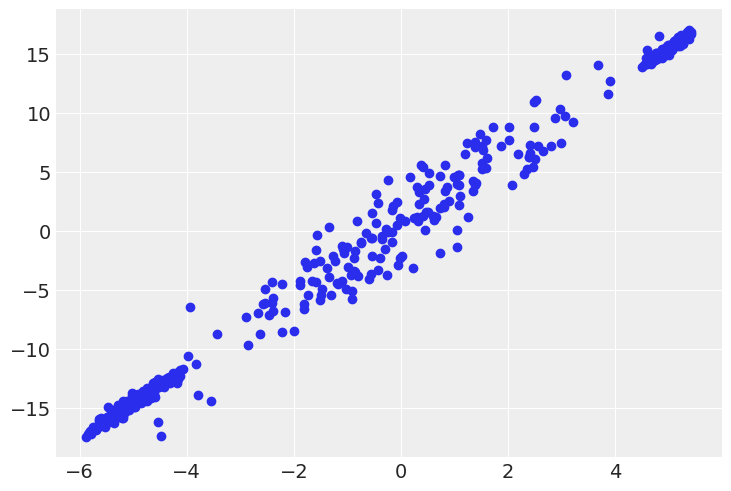

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

N, k = 500, 3
centers = np.array([-5, 0, 5])
sds = np.array([0.40, 2.0, 0.20])
idx = rng.integers(0, k, N)
true_a, true_b, predictor = 0.5, 3.0, rng.normal(loc=centers[idx], scale=sds[idx], size=N)
true_mu = true_a + true_b * predictor

outcome = rng.normal(loc=true_mu, scale=sds[idx], size=N)
predictor_scaled = standardize(predictor)
outcome_scaled = standardize(outcome)

# plt.hist(outcome_scaled, 25)
plt.plot(predictor, outcome, 'o')
plt.show()

In [3]:
from pymc.distributions import transforms

In [4]:
with pm.Model(coords={"cluster": range(k)}) as model:
    a = pm.Normal("a", 0.0, 10.0)
    b = pm.Normal("b", 0.0, 10.0)

    μ = pm.Deterministic("μ", var=a + b * predictor)
    
    σ = pm.HalfNormal("σ", sigma=1, dims="cluster")
    weights = pm.Dirichlet("w", np.ones(k), dims="cluster")    
    
    pm.NormalMixture("x", w=weights, mu=μ[..., None], sigma=σ, observed=outcome)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, σ, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 529 divergences after tuning. Increase `target_accept` or reparameterize.


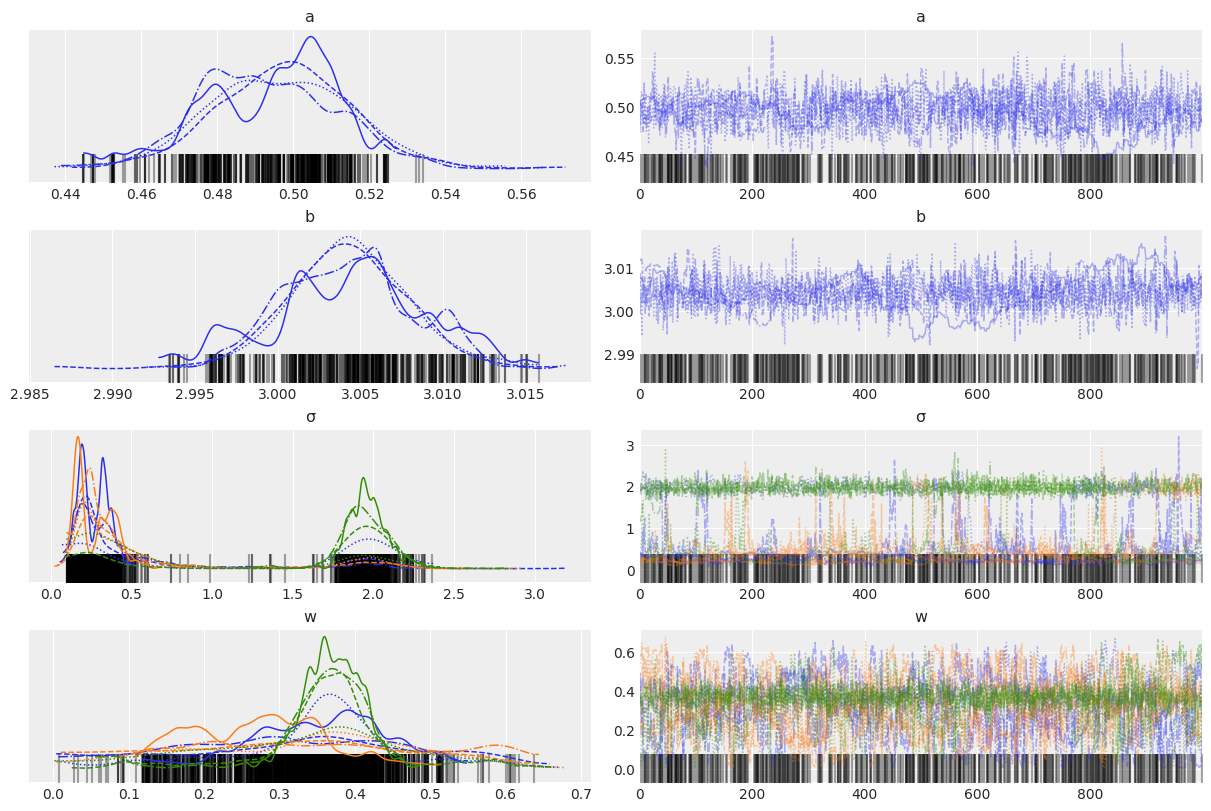

In [5]:
az.plot_trace(idata, var_names=['a', 'b', 'σ', 'w']);

In [6]:
with pm.Model(coords={"cluster": range(k)}) as model:
    a = pm.Normal("a", 0.0, 10.0)
    b = pm.Normal("b", 0.0, 10.0)

    μ = pm.Deterministic("μ", var=a + b * predictor)
    
    σ = pm.HalfNormal("σ", sigma=1, dims="cluster",
                      transform=transforms.Chain([
                          transforms.LogTransform(),
                          transforms.Ordered(0),
                      ]),
                      initval=np.asarray([1., 2., 3.])
                     )
    weights = pm.Dirichlet("w", np.ones(k), dims="cluster")    
    
    pm.NormalMixture("x", w=weights, mu=μ[..., None], sigma=σ, observed=outcome)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, σ, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


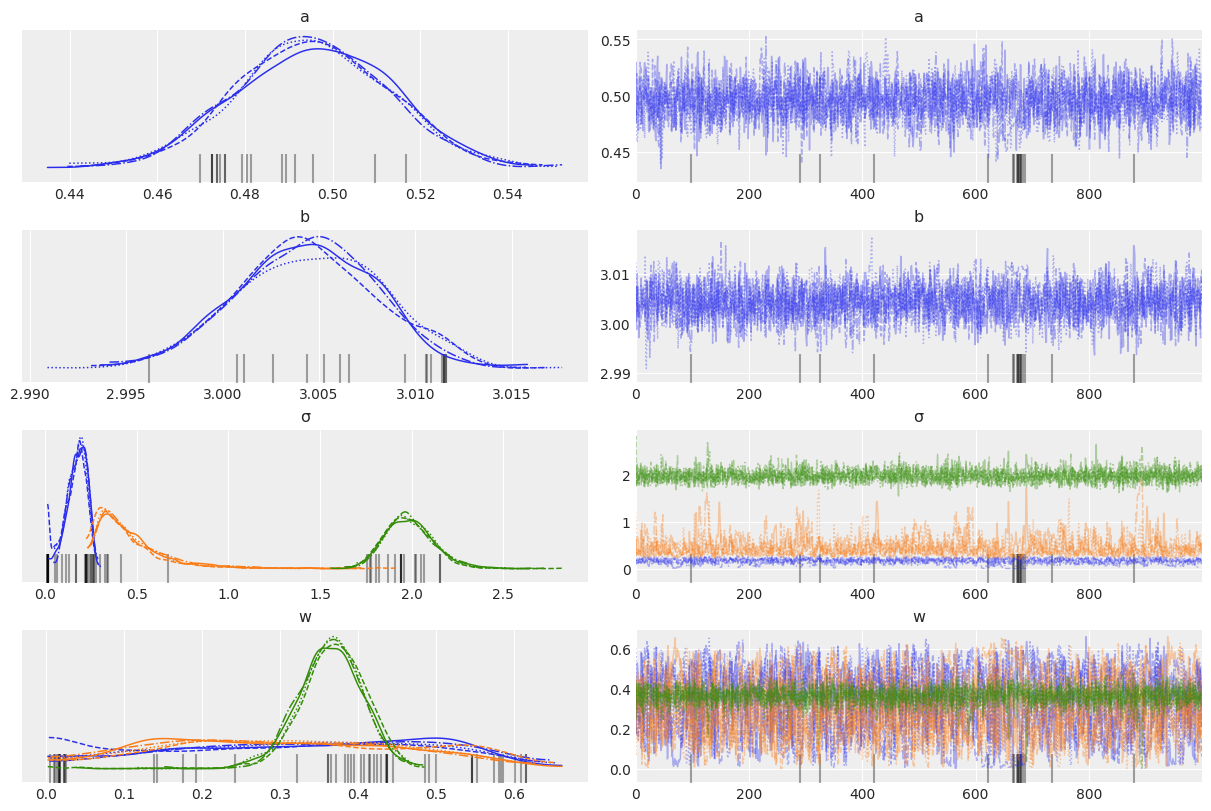

In [7]:
az.plot_trace(idata, var_names=['a', 'b', 'σ', 'w']);

In [10]:
with pm.Model(coords={"cluster": range(k)}) as model:
    a = pm.Normal("a", 0.0, 10.0)
    b = pm.Normal("b", 0.0, 10.0)
    pred_mu = pm.Normal("pred_mu", 0.0, 10.0, dims="cluster")
    σ = pm.HalfNormal("σ", sigma=1, dims="cluster",
                      transform=transforms.Chain([
                          transforms.LogTransform(),
                          transforms.Ordered(0),
                      ]),
                      initval=np.asarray([1., 2., 3.])
                     )
    
    weights = pm.Dirichlet("w", np.ones(k), dims="cluster")
    pred = pm.NormalMixture("pred", w=weights, mu=pred_mu, sigma=σ, observed=predictor)

    μ = pm.Deterministic("μ", var=a + b * pred)
    pm.NormalMixture("x", w=weights, mu=μ[..., None], sigma=σ, observed=outcome)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, pred_mu, σ, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.


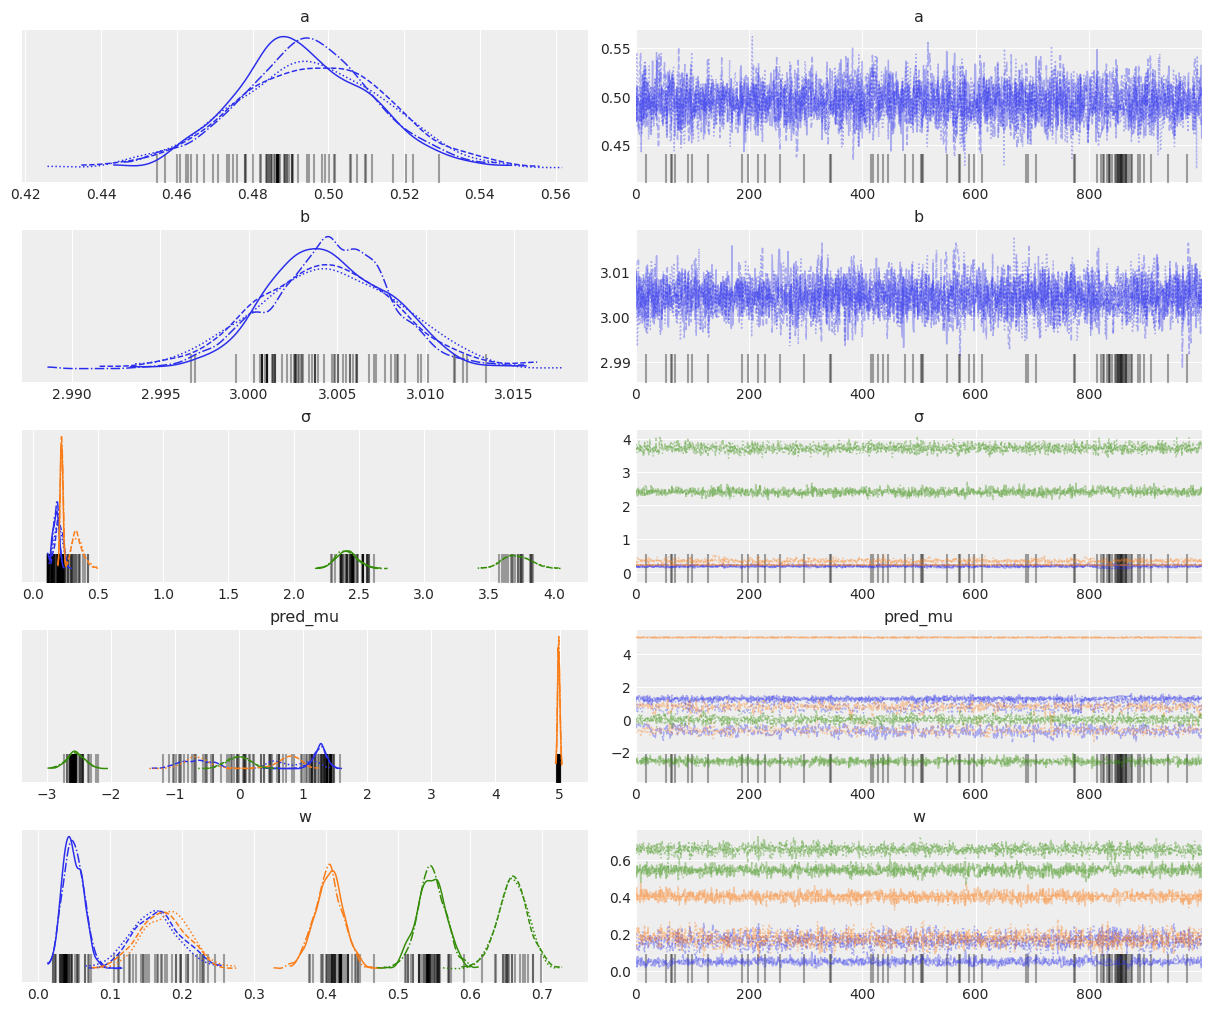

In [11]:
az.plot_trace(idata, var_names=['a', 'b', 'σ', 'pred_mu', 'w']);